In [2]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from util_data import *
from baseline_naive import *
from util_plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

('probtorch:', '0.0+5a2c637', 'torch:', '1.0.0.dev20181029', 'cuda:', True)


In [3]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 50
T_max = 60
K = 4
D = 2
dt = 6
Boundary = 30
noise_ratio = 10.0

## Model Parameters
num_particles= 50
num_particles_smc = 50
NUM_HIDDEN = 64
NUM_LATENTS = K*K
NUM_OBS = 2 * D

NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "baseline_smc/hao/baseline_smc-%dIS-enc-%s" % (num_particles, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

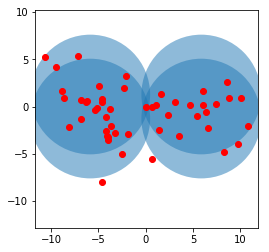

In [4]:
T_sample = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
STATE, Disp, A_true, Zs_true = generate_seq(T_sample, dt, Boundary, init_v, noise_cov)
## true global variables
cov_true = np.tile(noise_cov, (K, 1, 1))
dirs = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]])
mu_true = np.tile(np.absolute(init_v), (K, 1)) * dirs
plot_clusters(Disp, mu_true, cov_true, K)

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs):
        A_samples = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K)
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample()
        return latents_dirs, A_samples

In [6]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [7]:
KLs = []
EUBOs = []
ESSs = []
ELBOs = []
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    mu_ks, cov_ks, Pi, Y, A_true, Z_true = generate_seq_T(T, K, dt, Boundary, init_v, noise_cov)
    enc, eubo, kl, ess, latents_dirs, elbo = naive_sampling(enc, alpha_trans_0, Pi, mu_ks, cov_ks, Z_true, Y, T, D, K, num_particles)
    eubo.backward()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ESSs.append(ess / num_particles)
    ELBOs.append(elbo.item())
#     log_qs.append(loss_infer.item())
    optimizer.step()
    time_end = time.time()
    print('epoch : %d, eubo : %f, elbo : %f,  KL : %f (%ds)' % (epoch, eubo, elbo, kl, time_end - time_start))

if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)
    save_params(KLs, EUBOs, ESSs, PATH_ENC)

epoch : 0, eubo : -380.428284, elbo : -449.093567,  KL : 29.803888 (0s)
epoch : 1, eubo : -421.071594, elbo : -500.115204,  KL : 32.440987 (0s)
epoch : 2, eubo : -427.461823, elbo : -463.133270,  KL : 32.316528 (0s)
epoch : 3, eubo : -404.116913, elbo : -469.241241,  KL : 33.660461 (0s)
epoch : 4, eubo : -389.679230, elbo : -430.392456,  KL : 23.424116 (0s)
epoch : 5, eubo : -387.064178, elbo : -470.892578,  KL : 37.954071 (0s)
epoch : 6, eubo : -413.217926, elbo : -492.744507,  KL : 34.416946 (0s)
epoch : 7, eubo : -364.981567, elbo : -417.869873,  KL : 25.283821 (0s)
epoch : 8, eubo : -420.487854, elbo : -495.473907,  KL : 35.179283 (0s)
epoch : 9, eubo : -432.454468, elbo : -496.789795,  KL : 31.522995 (0s)
epoch : 10, eubo : -421.143402, elbo : -463.208405,  KL : 32.054844 (0s)
epoch : 11, eubo : -378.367676, elbo : -432.337372,  KL : 22.120522 (0s)
epoch : 12, eubo : -418.194305, elbo : -466.366913,  KL : 31.107195 (0s)
epoch : 13, eubo : -414.860168, elbo : -462.347351,  KL : 30.

variational : 
tensor([[ 3.9131,  2.8757,  1.5814,  2.1496],
        [ 1.7800, 11.0797,  1.6882,  1.2019],
        [ 1.4782,  1.3788,  1.6894, 14.4699],
        [ 1.6704,  1.4846,  2.0250,  6.5340]], grad_fn=<ViewBackward>)
conjugate posterior :
tensor([[14.,  2.,  1.,  2.],
        [ 1., 10.,  3.,  1.],
        [ 2.,  1., 14.,  2.],
        [ 2.,  1.,  2., 15.]])


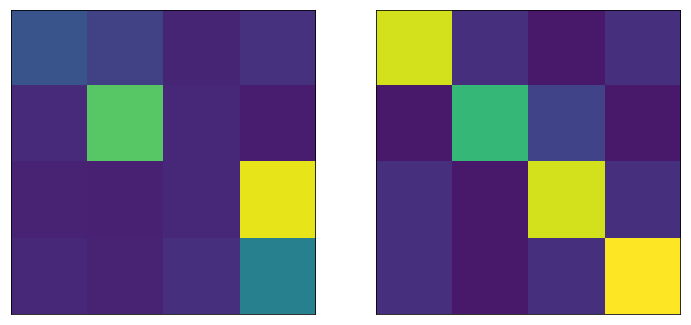

In [16]:
plot_dirs(latents_dirs, alpha_trans_0, Z_true, T, K, vmax=15)

In [ ]:
plot_results(EUBOs, KLs, ESSs)

In [15]:
def plot_dirs(latents_dirs, alpha_trans_0, Zs_true, T, K, vmax):
    conjugate_post = alpha_trans_0 + pairwise(Zs_true, T).sum(0)
    print('variational : ')
    print(latents_dirs)
    print('conjugate posterior :')
    print(conjugate_post)

    fig3 = plt.figure(figsize=(12,6))
    ax1 = fig3.add_subplot(1, 2, 1)
    infer_plot = ax1.imshow(latents_dirs.data.numpy(), cmap='viridis', vmin=0, vmax=vmax)
    ax1.set_xticks([])
    ax1.set_yticks([])
    #ax1.set_title('variational')
    ax2 = fig3.add_subplot(1, 2, 2)
    true_plot = ax2.imshow(conjugate_post.data.numpy(), cmap='viridis', vmin=0, vmax=vmax)
    ax2.set_xticks([])
    ax2.set_yticks([])
    #ax2.set_title('conjugate posterior')
    #cax = fig3.add_axes([1.0, 0.15, 0.03, 0.7])
    #fig3.colorbar(true_plot, cax=cax, orientation='vertical')
    # cbaxes = fig3.add_axes([0.95, 0.32, 0.02, 0.36])
    # cb = plt.colorbar(true_plot, cax = cbaxes)
    fig3.savefig('baseline_naive_transition.png', dpi=600)
    fig3.savefig('baseline_naive_transition.svg', dpi=600)
    fig3.savefig('baseline_naive_transition.svg', dpi=600)

In [18]:
conjugate_post = alpha_trans_0 + pairwise(Z_true, T).sum(0)

In [19]:
conjugate_post

tensor([[14.,  2.,  1.,  2.],
        [ 1., 10.,  3.,  1.],
        [ 2.,  1., 14.,  2.],
        [ 2.,  1.,  2., 15.]])

In [22]:
def plot_circle_transition_colorcode(As_infer, width_space, height_space, cov_flag, legend_flag, save_flag):


    fig = plt.figure(figsize=(fs*1.5 + width_space,fs + height_space))

    gs2 = gridspec.GridSpec(4, 1)
    gs2.update(left=2/3 + (1/3)*width_space, bottom=0.5+(1/2)*width_space, right=1.0, top=1.0, wspace=0, hspace=0)
    ax2 = fig.add_subplot(gs2[0, 0])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs2[1, 0])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs2[2, 0])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs2[3, 0])
    ax5.set_xticks([])
    ax5.set_yticks([])



    ax2.imshow(As_infer[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax3.imshow(As_infer[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax4.imshow(As_infer[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax5.imshow(As_infer[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    fig.savefig('baseline_naive_transition.pdf', bbox_inches='tight')
    fig.savefig('baseline_naive_transition', bbox_inches='tight')
    fig.savefig('baseline_naive_transition.png', dpi=600, bbox_inches='tight')

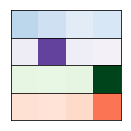

In [23]:
fs = 3.0 ## figure size
vmax = 14 ## cmap maximum value, to make off-diagonal elements more visible
width_space = 0.05 # space between figures
height_space = 0.05 # space between figures
cov_flag = False # plot the covariances or not
legend_flag = False # plot the legend bar or not
save_flag = True ## save or not
plot_circle_transition_colorcode(latents_dirs.data.numpy(), width_space, height_space, cov_flag, legend_flag, save_flag)
